In [19]:
import time
import matplotlib.pyplot as plt
from higher_functions import *
import multiprocess as mp

In [20]:
nprocs = mp.cpu_count()
pool = mp.Pool(processes=nprocs)

def find_sol(nodes_target, rparams):
    ri, rf, dr = rparams
    steps = int((rf - ri)//dr)
    
    bpoint = 0
    phi0 = np.random.uniform(-2,0)

    nsteps = 5000
    count, step_stdev, nneighboors = 0, 1, nprocs
    for i in np.arange(nsteps):
        # Give a random kick to phi0
        phi0old = phi0
        allphi0s = np.array([phi0]*nneighboors) + np.random.normal(0,step_stdev,nneighboors)

        mcs = pool.starmap(mc_step, [(phi0here, bpoint, nodes_target, rparams) for phi0here in allphi0s])
        bpoints = np.array([mc[1] for mc in mcs])
        bpoint_max = np.amax(bpoints)
        index_max = np.where(bpoints == bpoint_max)[0]

        if bpoint_max > bpoint:  # If a larger 'bpoint' is found, keep
            bpoint = bpoint_max
            phi0 = allphi0s[index_max][0]
        else:   # If not, back to old valur of phi0
            count += 1
        
        # Variable 'count' avoids the code 'getting stuck' for large periods of time, makes step smaller when it happens
        if count > 2:
            count = 0
            step_stdev = step_stdev/10

        # If the solution does not break in the interval or step is too small, stop
        if bpoint == steps - 1 or step_stdev < 1e-20:
            return phi0, bpoint

    return phi0, bpoint

In [21]:
rparams = 0, 60, 0.01 # rparams in the format ri, rf, dr
ri, rf, dr = rparams
steps = int((rf - ri)//dr)
rinterv = np.linspace(ri, rf, steps, endpoint=True)

# Find solutions with number of nodes from nodes_min to nodes_max
nodes_min, nodes_max = 1, 8
nodes_lst = np.arange(nodes_min, nodes_max + 1)

start_time = time.time()
all_phi0s = []
for node in nodes_lst:
    thisphi0 = find_sol(node, rparams)[0]
    all_phi0s.append(thisphi0)

    print('Found solution for ', node, ' nodes. It took ', np.round((time.time() - start_time)/60, 2), ' minutes.')
    start_time = time.time()


# # Save phi0s for all the different number of nodes
# a_file = open("output/allphis.txt", "w")

# np.savetxt(a_file, all_phi0s)

# a_file.close()

Found solution for  1  nodes. It took  0.44  minutes.
Found solution for  2  nodes. It took  0.55  minutes.
Found solution for  3  nodes. It took  0.67  minutes.
Found solution for  4  nodes. It took  0.79  minutes.
Found solution for  5  nodes. It took  0.85  minutes.
Found solution for  6  nodes. It took  1.08  minutes.
Found solution for  7  nodes. It took  1.17  minutes.
Found solution for  8  nodes. It took  0.78  minutes.


The value of epsilonb is:  0.648267211173261
The value of tilde phi0 is:  -0.8556236382949536


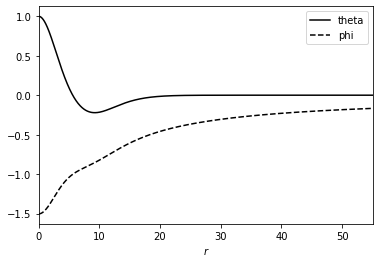

In [22]:
# all_phi0s = np.loadtxt('output/allphis.txt')

# Plotting solution with number of nodes equal to nodes_target
nodes_target = 1
phi0_plt = all_phi0s[nodes_target - 1]
Xbc_plt = np.array([1, 0, phi0_plt, 0])
Xs, bpoint, nodes = rk4(Xbc_plt, nodes_target)
rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]

epsilonb = find_epsilonb(rinterv_cut, Xs)[0]
print('The value of epsilonb is: ', epsilonb)
print('The value of tilde phi0 is: ', Xs[2].T[0])


plt.plot(rinterv_cut, Xs[0].T, 'k-', label = "theta")
plt.plot(rinterv_cut, Xs[2].T - epsilonb, 'k--', label = "phi")
plt.xlabel(r"$r$")
plt.xlim(left = 0, right = rinterv[bpoint])
plt.legend();

# name_file = 'plots/' + str(nodes_target) + 'nodes.pdf'
# plt.savefig(name_file, dpi = 300, bbox_inches='tight')


In [110]:
# Save all plots
for i, phi0 in enumerate(all_phi0s):
    nodes_here = i + 1
    Xbc_plt = np.array([1, 0, phi0, 0])
    Xs, bpoint, nodes = rk4(Xbc_plt, nodes_here)
    rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]
    epsilonb = find_epsilonb(rinterv_cut, Xs)[0]

    plt.plot(rinterv_cut, Xs[0].T, 'k-', label = "theta")
    plt.plot(rinterv_cut, Xs[2].T - epsilonb, 'k--', label = "phi")
    plt.xlabel(r"$r$")
    plt.xlim(left = 0, right = rinterv[bpoint])
    textstr = 'n = ' + str(nodes_here)
    plt.text(0.90, 0.925, textstr, fontsize=14, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    name_file = 'plots/' + str(nodes_here) + 'nodes.pdf'
    plt.savefig(name_file, dpi = 300, bbox_inches='tight')
    plt.close()